In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import shapefile as shp
#opening the vector map
shp_path1 = r'D:\Python\lidar\Export_Output.shp'
#reading the shape file by using reader function of the shape lib
sf1 = shp.Reader(shp_path1)
len(sf1.shapes())
sf1.records()
def read_shapefile(sf1):
    #fetching the headings from the shape file
    fields1 = [x[0] for x in sf1.fields][1:]
#fetching the records from the shape file
    records1 = [list(i) for i in sf1.records()]
    shps1 = [s.points for s in sf1.shapes()]
#converting shapefile data into pandas dataframe
    df = pd.DataFrame(columns=fields1, data=records1)
#assigning the coordinates
    df = df.assign(coords=shps1)
    return df
df = read_shapefile(sf1)
df.shape
df.sample(11)
df = df[['Date','max']]
df.head()
df.tail()

,Date,max
8,2020-01-09,17.025
9,2020-01-10,17.035
10,2020-01-11,17.042
11,2020-01-12,17.051
12,2021-01-01,17.052


In [3]:
df.index.freq='MS'

In [4]:
df.head()

,Date,max
0,2020-01-01,17.009674
1,2020-01-02,17.010000
2,2020-01-03,17.015000
3,2020-01-04,17.016000
4,2020-01-05,17.016500


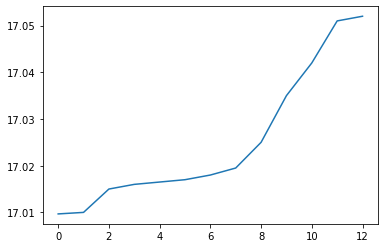

In [5]:
plt.plot(df['max'])


In [6]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df['max'])

1. ADF :  0.31853578875450145
2. P-Value :  0.9781790966218605
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression: 8
5. Critical Values :
	 1% :  -4.6651863281249994
	 5% :  -3.3671868750000002
	 10% :  -2.802960625


In [7]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['max'], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-93.193, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-98.096, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-98.407, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-95.642, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-91.466, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-96.362, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-95.904, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-94.550, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-98.141, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.873 seconds


In [8]:
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape,test.shape)

(13, 2)
(0, 2) (13, 2)


In [9]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['max'],order=(1,1,0))
model=model.fit()
model.summary()

C:\Users\singh\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\singh\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\singh\miniconda3\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
C:\Users\singh\miniconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\singh\miniconda3\lib\site-packages\statsmodels\base\model.py:531: RuntimeWarning: invalid value encountered in double_scalars
  return -self.loglike(params, *args) / nobs
C:\Users\singh\miniconda3\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    max   No. Observations:                    0
Model:                 ARIMA(1, 1, 0)   Log Likelihood                   0.000
Date:                Mon, 29 Nov 2021   AIC                              4.000
Time:                        10:02:36   BIC                                nan
Sample:                             0   HQIC                               nan
                                  - 0                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
sigma2            nan         -0        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

<AxesSubplot:>

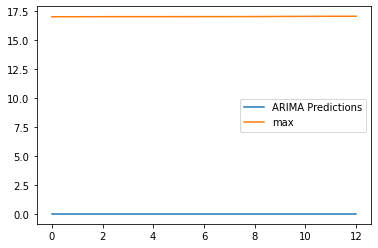

In [10]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['max'].plot(legend=True)

In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['max'].mean()
rmse=sqrt(mean_squared_error(pred,test['max']))
print(rmse)

17.025134761795133


In [12]:
from statsmodels.tsa.arima.model import ARIMA
model2=ARIMA(df['max'],order=(1,1,0))
n= model2.fit()

In [20]:
index_future_dates=pd.date_range(start='2020-12-01', end='2023-12-31',freq='1m').rename('Date')

In [21]:
pred= n.predict(start=len(df),end=len(df)+36,typ='levels',exog =df[['max']]).rename('max')

In [22]:
df.head(),df.tail()

(         Date        max
 0  2020-01-01  17.009674
 1  2020-01-02  17.010000
 2  2020-01-03  17.015000
 3  2020-01-04  17.016000
 4  2020-01-05  17.016500,
           Date     max
 8   2020-01-09  17.025
 9   2020-01-10  17.035
 10  2020-01-11  17.042
 11  2020-01-12  17.051
 12  2021-01-01  17.052)

In [23]:

pred.index=index_future_dates
pred

Date
2020-12-31    17.052740
2021-01-31    17.053287
2021-02-28    17.053692
2021-03-31    17.053992
2021-04-30    17.054213
2021-05-31    17.054377
2021-06-30    17.054499
2021-07-31    17.054588
2021-08-31    17.054655
2021-09-30    17.054704
2021-10-31    17.054740
2021-11-30    17.054767
2021-12-31    17.054787
2022-01-31    17.054802
2022-02-28    17.054813
2022-03-31    17.054821
2022-04-30    17.054827
2022-05-31    17.054831
2022-06-30    17.054834
2022-07-31    17.054837
2022-08-31    17.054839
2022-09-30    17.054840
2022-10-31    17.054841
2022-11-30    17.054842
2022-12-31    17.054842
2023-01-31    17.054843
2023-02-28    17.054843
2023-03-31    17.054843
2023-04-30    17.054843
2023-05-31    17.054843
2023-06-30    17.054843
2023-07-31    17.054843
2023-08-31    17.054844
2023-09-30    17.054844
2023-10-31    17.054844
2023-11-30    17.054844
2023-12-31    17.054844
Freq: M, Name: max, dtype: float64

<AxesSubplot:xlabel='Date'>

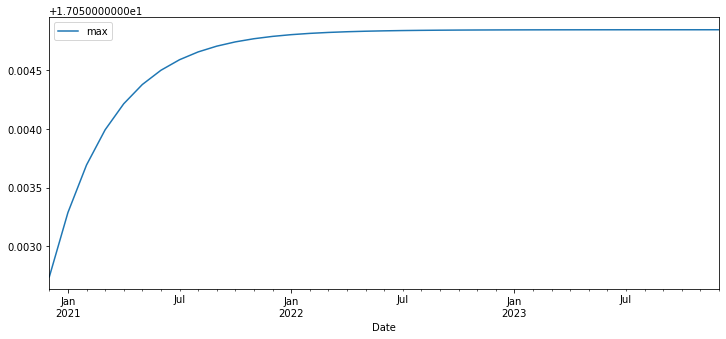

In [24]:
pred.plot(figsize=(12,5), legend=True)

<AxesSubplot:>

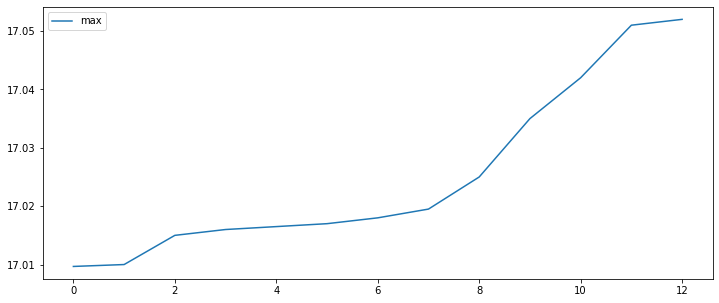

In [25]:
df.plot(figsize=(12,5), legend=True)

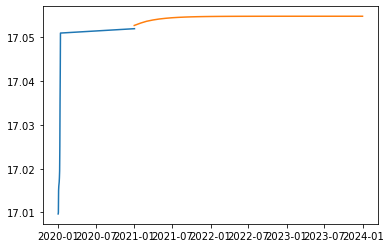

In [26]:
plt.plot(df['Date'], df['max'])
plt.plot(pred)